In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, lars_path
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve,f1_score, roc_auc_score, roc_curve, log_loss,classification_report

from ipywidgets import interactive

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('Airline_Dataset.csv')

# Data Cleaning
#### The columns in the dataframe are cleaned and reorganized:
- Column names are renamed.
- Elements in Features 'Customer Type' and 'Class' are renamed.
- Rows with Null values are removed.
- Rows with scores of 0 in the survey of satisfaction are removed (Customers probably did not indicate).
- Departure Delay and Arrival Delay are combined.
- Satisfaction target is relabelled as 0 and 1.

In [3]:
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
129876,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
129877,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
129878,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

In [5]:
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':'Returning Customer','disloyal Customer':'First-time Customer'})

In [6]:
df = df.dropna(axis=0)

In [7]:
df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].astype('float')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   Gender                             129487 non-null  object 
 2   Customer Type                      129487 non-null  object 
 3   Age                                129487 non-null  int64  
 4   Type of Travel                     129487 non-null  object 
 5   Class                              129487 non-null  object 
 6   Flight Distance                    129487 non-null  int64  
 7   Inflight wifi service              129487 non-null  int64  
 8   Departure/Arrival time convenient  129487 non-null  int64  
 9   Ease of Online booking             129487 non-null  int64  
 10  Gate location                      129487 non-null  int64  
 11  Food and drink                     1294

In [9]:
df.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,64958.335169,39.428761,1190.210662,2.728544,3.057349,2.756786,2.976909,3.204685,3.252720,3.441589,3.358067,3.383204,3.351078,3.631886,3.306239,3.642373,3.286222,14.643385,15.091129
std,37489.781165,15.117597,997.560954,1.329235,1.526787,1.401662,1.278506,1.329905,1.350651,1.319168,1.334149,1.287032,1.316132,1.180082,1.266146,1.176614,1.313624,37.932867,38.465650
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32494.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64972.000000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97415.500000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [10]:
df = df.rename(columns={'Leg room service':'Leg room'})


In [11]:
from string import capwords
df.columns = [capwords(i) for i in df.columns]
df = df.rename(columns={'Departure/arrival Time Convenient':'Departure/Arrival Time Convenience'})

In [12]:
df

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Arrival Delay In Minutes,Satisfaction
0,70172,Male,Returning Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25.0,18.0,neutral or dissatisfied
1,5047,Male,First-time Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1.0,6.0,neutral or dissatisfied
2,110028,Female,Returning Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0.0,0.0,satisfied
3,24026,Female,Returning Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11.0,9.0,neutral or dissatisfied
4,119299,Male,Returning Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,78463,Male,First-time Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,0.0,neutral or dissatisfied
129876,71167,Male,Returning Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0.0,0.0,satisfied
129877,37675,Female,Returning Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0.0,neutral or dissatisfied
129878,90086,Male,Returning Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,0.0,satisfied


In [13]:
df = df[(df['Inflight Wifi Service']!=0)&(df['Departure/Arrival Time Convenience']!=0)&(df['Ease Of Online Booking']!=0)&(df['Gate Location'])&(df['Food And Drink']!=0)&(df['Online Boarding']!=0)&(df['Seat Comfort']!=0)&(df['Inflight Entertainment']!=0)&(df['On-board Service']!=0)&(df['Leg Room']!=0)&(df['Baggage Handling']!=0)&(df['Checkin Service']!=0)&(df['Inflight Service']!=0)&(df['Cleanliness']!=0)]

In [14]:
df['Satisfaction'] = df['Satisfaction'].map({'satisfied':1,'neutral or dissatisfied':0})
df = df.reset_index()
df = df.drop('index',axis=1)
df['Total Delay'] = df['Departure Delay In Minutes'] + df['Arrival Delay In Minutes']


In [15]:
DF = df.copy()
df = df.drop('Id',axis=1)

In [16]:
df = df.reindex(columns=['Satisfaction']+list(df.columns)[:-2]+['Total Delay'])
df = df.drop(['Departure Delay In Minutes','Arrival Delay In Minutes'],axis=1)

In [17]:
df['Satisfaction'].value_counts(normalize=True)

0    0.564257
1    0.435743
Name: Satisfaction, dtype: float64

In [18]:
df['Class'] = df['Class'].map({'Eco':'Economy','Eco Plus':'Economy','Business':'Business'})

In [123]:
df

,Satisfaction,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay
0,0,Male,Returning Customer,13,Personal Travel,Economy,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,43.0
1,0,Male,First-time Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,7.0
2,0,Female,Returning Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,20.0
3,1,Male,Returning Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0
4,0,Female,Returning Customer,26,Personal Travel,Economy,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69061,0,Female,First-time Customer,36,Business travel,Economy,432,1,5,1,3,4,1,4,4,5,2,5,2,3,4,0.0
69062,0,Male,First-time Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0
69063,0,Female,Returning Customer,17,Personal Travel,Economy,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0
69064,1,Male,Returning Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0


# Exploratory Data Analysis and Feature Selection

#### Create visualizations to first understand business problem, and also identify important features for model building:
- Find out proportion of classes in target, and split them by Type of Travel and Type of Customers (To understand trend of satisfaction - useful later in model evaluation)
- Identify feature significance for model through visualizing KDE plots, LASSO path and heatmap.
- After evaluation and discreet selection, I have decided to drop 'Gender, 'Total Delay','Flight Distance','Age','Gate Location' and 'Departure/Arrival Time Convenience'

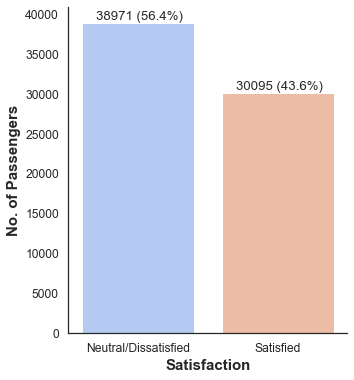

In [20]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',palette='coolwarm')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df)*100).round(1))+'%)', (p.get_x()+0.1, p.get_height()+400))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
sns.despine()
plt.savefig('targetplot1.png',transparent=True, bbox_inches='tight')

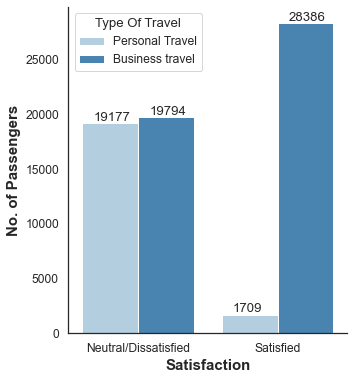

In [21]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',hue='Type Of Travel',palette='Blues')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.08, p.get_height()+200))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
sns.despine()
plt.savefig('targetplot2.png',transparent=True, bbox_inches='tight')

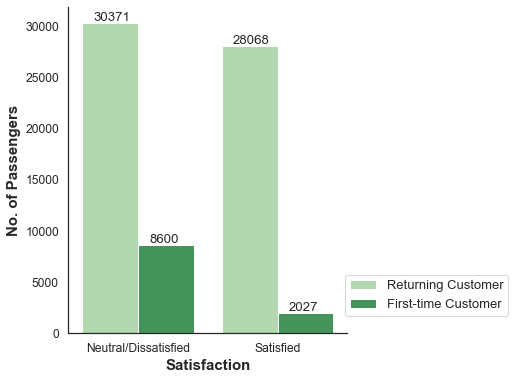

In [22]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',hue='Customer Type',palette='Greens')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.08, p.get_height()+200))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
plt.legend(loc="upper right", bbox_to_anchor=(1.6, 0.2),fontsize=13)
sns.despine()
plt.savefig('targetplot3.png',transparent=True, bbox_inches='tight')

In [23]:
df1 = pd.get_dummies(df,columns=['Gender','Customer Type','Type Of Travel','Class'],drop_first=True)
df1

,Satisfaction,Age,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay,Gender_Male,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
0,0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,43.0,1,1,1,1
1,0,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,7.0,1,0,0,0
2,0,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,20.0,0,1,0,0
3,1,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0,1,1,0,0
4,0,26,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69061,0,36,432,1,5,1,3,4,1,4,4,5,2,5,2,3,4,0.0,0,0,0,1
69062,0,34,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,1,0,0,0
69063,0,17,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0,1,1,1
69064,1,14,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,1,1,0,0


In [24]:
df['Inflight Wifi Service'].value_counts()

3    20681
1    14925
2    13417
5    10977
4     9066
Name: Inflight Wifi Service, dtype: int64

In [25]:
group = df1.groupby(['Satisfaction','Class_Economy'])['Class_Economy'].count()
group

Satisfaction  Class_Economy
0             0                10710
              1                28261
1             0                23593
              1                 6502
Name: Class_Economy, dtype: int64

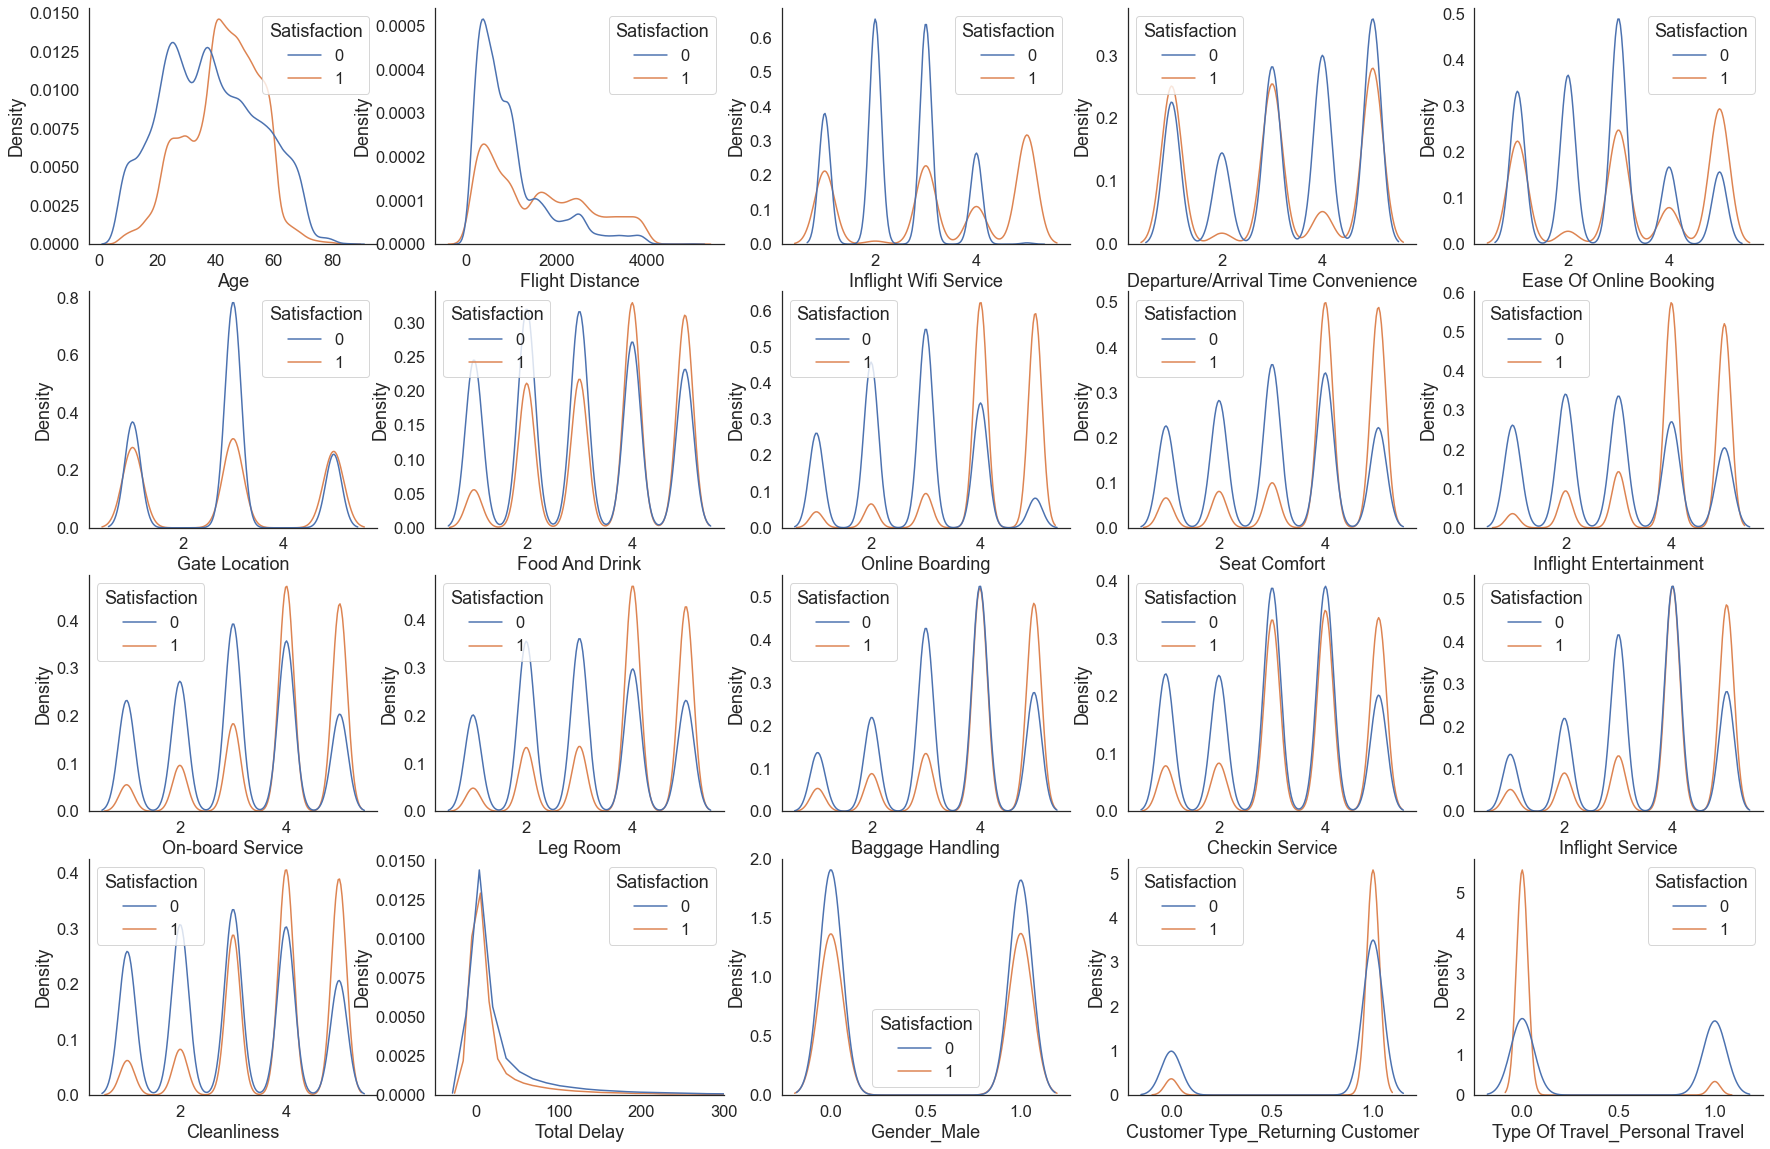

In [26]:
sns.set(style='white',font_scale=1.5)
fig = plt.figure(figsize=[30,20])
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    sns.kdeplot(data=df1,x=df1.columns[i+1],hue='Satisfaction')
    if i == 16:
        plt.xlim([-50,300])
    sns.despine()
    plt.savefig('kdeplot.png',transparent=True, bbox_inches='tight')

In [27]:
df1 = df1.drop('Gender_Male',axis=1)

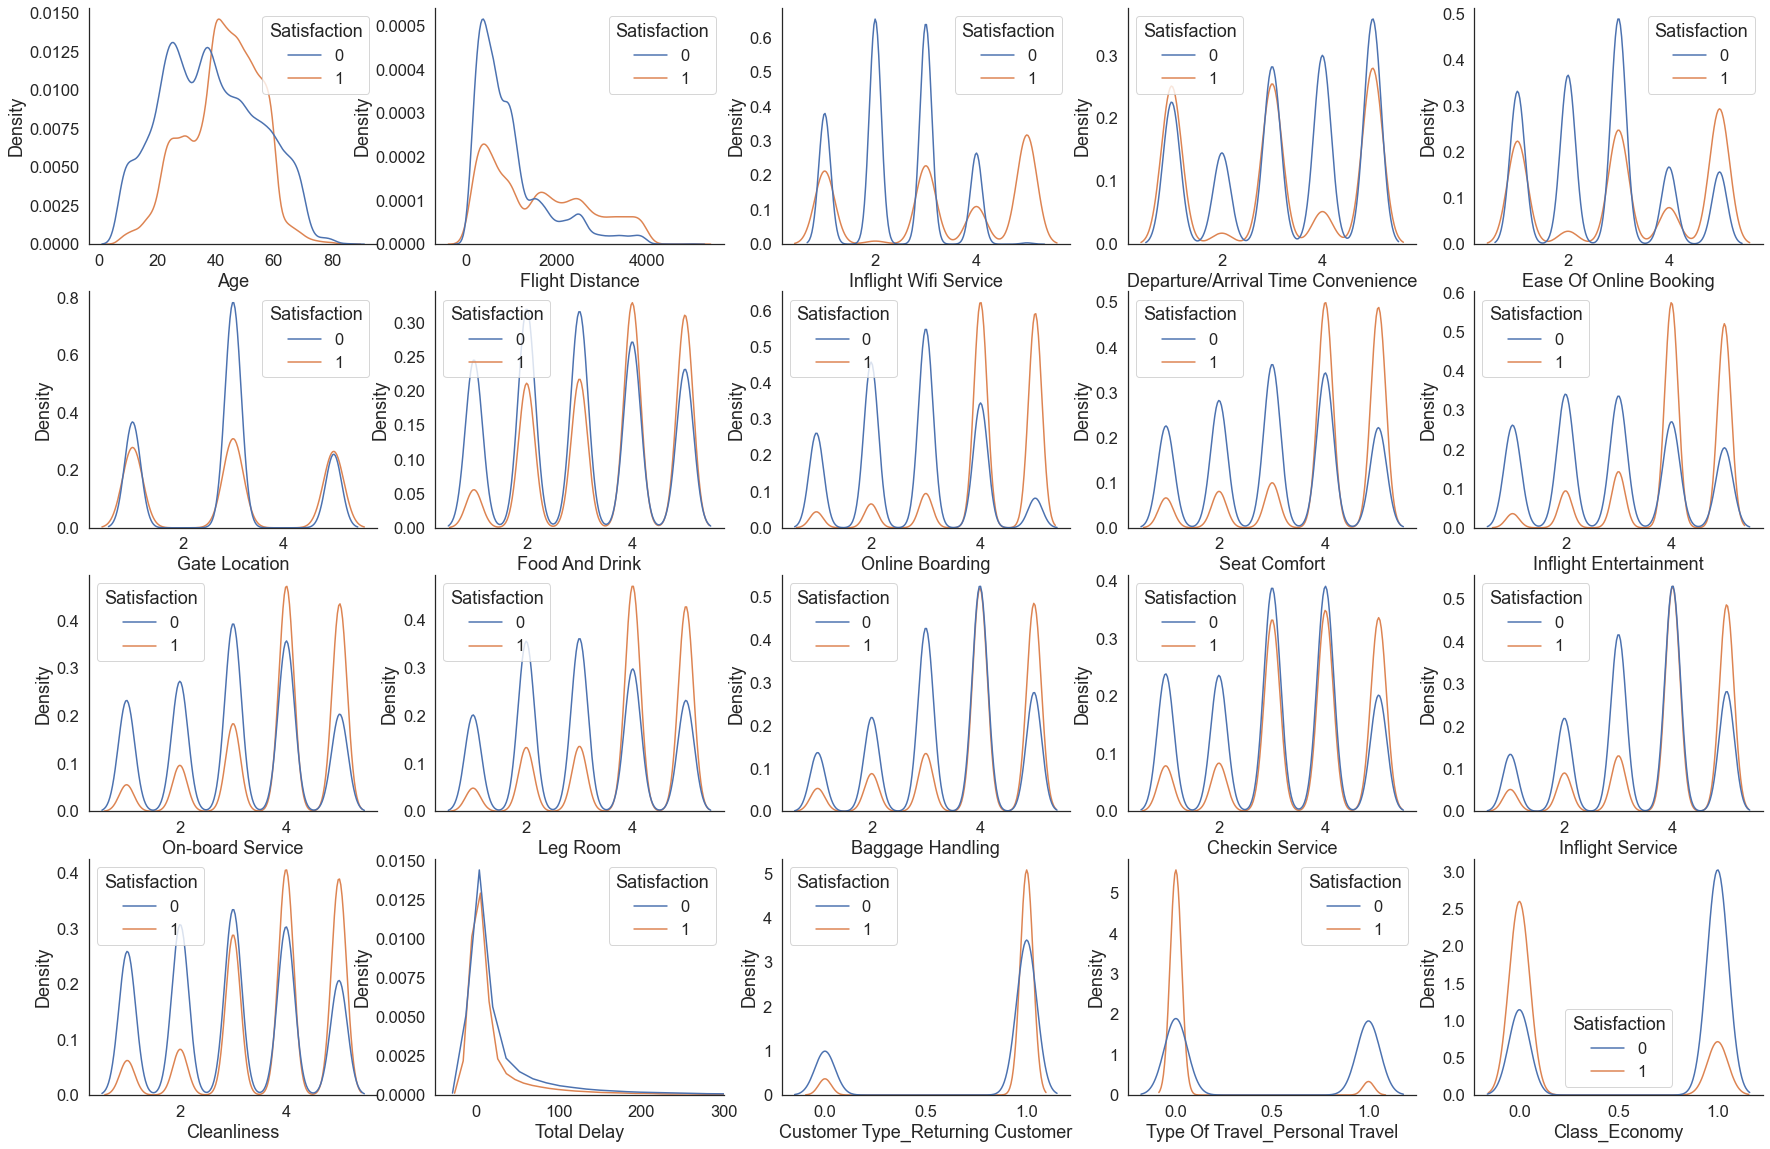

In [28]:
sns.set(style='white',font_scale=1.5)
fig = plt.figure(figsize=[30,20])
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    sns.kdeplot(data=df1,x=df1.columns[i+1],hue='Satisfaction')
    if i == 16:
        plt.xlim([-50,300])
    sns.despine()

In [29]:
corr_matrix = df1.corr()
corr_matrix

,Satisfaction,Age,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
Satisfaction,1.000000,0.150330,0.303677,0.348541,-0.070339,0.204093,0.043578,0.229684,0.566547,0.372681,0.444786,0.345886,0.344405,0.270842,0.237069,0.268040,0.331106,-0.055746,0.210703,-0.469940,-0.504920
Age,0.150330,1.000000,0.083523,0.015717,-0.018813,0.017418,0.016286,0.022591,0.190272,0.159516,0.081202,0.064508,0.053213,-0.040651,0.037817,-0.046491,0.055343,-0.016000,0.248931,-0.065730,-0.137597
Flight Distance,0.303677,0.083523,1.000000,0.005510,-0.076475,0.050290,0.031325,0.057600,0.195383,0.154670,0.132126,0.115268,0.134143,0.069399,0.074036,0.061872,0.095962,-0.000989,0.199221,-0.280260,-0.468605
Inflight Wifi Service,0.348541,0.015717,0.005510,1.000000,0.441308,0.672462,0.443898,0.141383,0.420391,0.135243,0.216028,0.119044,0.151017,0.111939,0.051640,0.102409,0.144782,-0.025515,0.012180,-0.119000,-0.039514
Departure/Arrival Time Convenience,-0.070339,-0.018813,-0.076475,0.441308,1.000000,0.576451,0.596772,-0.010922,0.043472,-0.020132,-0.036836,0.061496,-0.005752,0.068147,0.099593,0.069379,-0.004830,-0.005037,0.090479,0.257842,0.129964
Ease Of Online Booking,0.204093,0.017418,0.050290,0.672462,0.576451,1.000000,0.599579,0.024465,0.311904,0.024961,0.031309,0.024647,0.079828,0.018964,0.010062,0.017221,0.012290,-0.010531,0.028937,-0.122754,-0.104740
Gate Location,0.043578,0.016286,0.031325,0.443898,0.596772,0.599579,1.000000,0.003245,0.025883,0.016101,0.014691,-0.008573,0.009167,-0.001322,-0.023836,-0.004327,0.000937,0.001105,0.034772,-0.072084,-0.048318
Food And Drink,0.229684,0.022591,0.057600,0.141383,-0.010922,0.024465,0.003245,1.000000,0.263983,0.565449,0.607716,0.065210,0.035821,0.038652,0.096476,0.038172,0.643129,-0.024135,0.057759,-0.069419,-0.089825
Online Boarding,0.566547,0.190272,0.195383,0.420391,0.043472,0.311904,0.025883,0.263983,1.000000,0.454027,0.318849,0.171895,0.141128,0.100118,0.225618,0.090729,0.366401,-0.033037,0.184988,-0.220551,-0.321064
Seat Comfort,0.372681,0.159516,0.154670,0.135243,-0.020132,0.024961,0.016101,0.565449,0.454027,1.000000,0.607696,0.144117,0.114395,0.082143,0.202177,0.079402,0.674680,-0.029623,0.151569,-0.134707,-0.237519


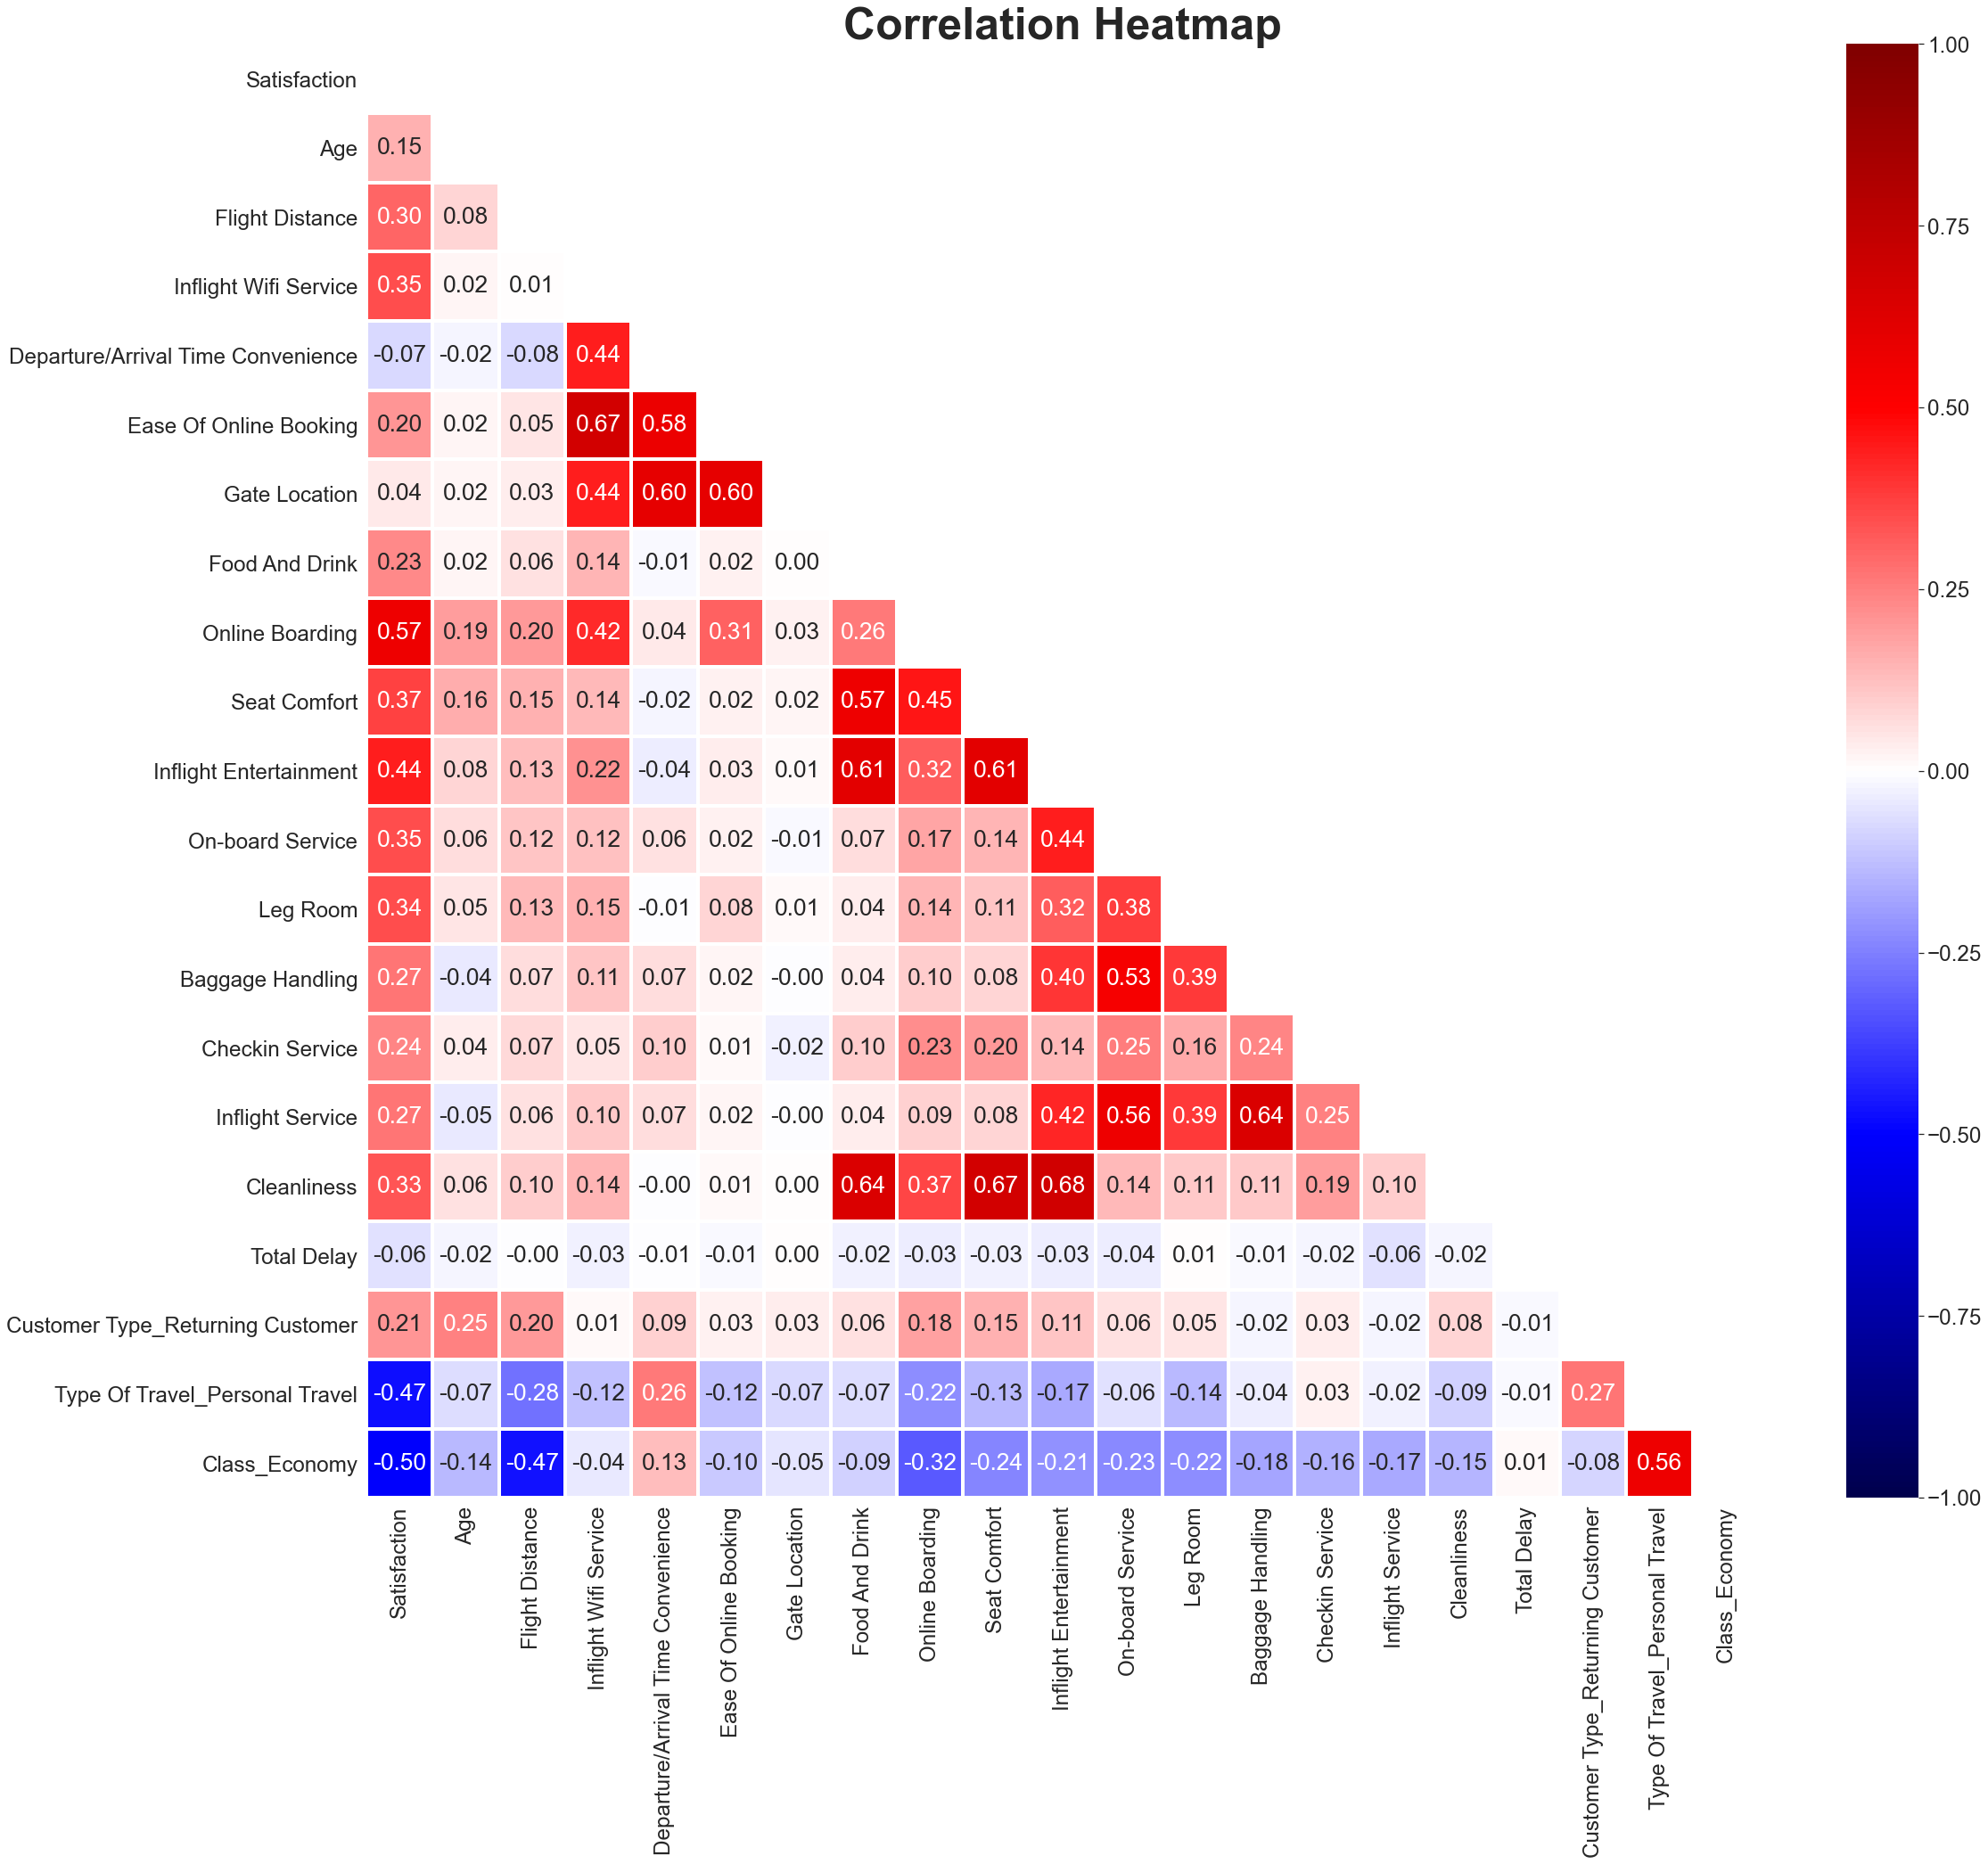

In [30]:
sns.set(style='white',font_scale=2.2)
fig = plt.figure(figsize=[35,30])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(150, 0, as_cmap=True)
sns.heatmap(corr_matrix,cmap='seismic',linewidth=3,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=50)
plt.savefig('heatmap.png',transparent=True, bbox_inches='tight')

In [31]:
y = df1['Satisfaction']
X = df1.drop('Satisfaction',axis=1)

In [32]:
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)

In [33]:
lasso_model = Lasso(alpha = 0.01)    
selected_columns = list(X.columns)
lasso_model.fit(X, y)
list(zip(selected_columns, lasso_model.coef_))

[('Age', 0.00013145369281497164),
 ('Flight Distance', 2.6269934798460135e-05),
 ('Inflight Wifi Service', 0.05833828264907208),
 ('Departure/Arrival Time Convenience', -0.025703769332411256),
 ('Ease Of Online Booking', -0.0),
 ('Gate Location', -0.0008139404744525279),
 ('Food And Drink', -0.0),
 ('Online Boarding', 0.10613247167886887),
 ('Seat Comfort', 0.0006954566176312981),
 ('Inflight Entertainment', 0.03632281604858479),
 ('On-board Service', 0.033328825175459396),
 ('Leg Room', 0.0364518947737136),
 ('Baggage Handling', 0.012697120797113723),
 ('Checkin Service', 0.028862631954215345),
 ('Inflight Service', 0.010451226725440722),
 ('Cleanliness', 0.0118562187217933),
 ('Total Delay', -0.00021462740634962295),
 ('Customer Type_Returning Customer', 0.18930324919633668),
 ('Type Of Travel_Personal Travel', -0.28411668082788655),
 ('Class_Economy', -0.08783294972847767)]

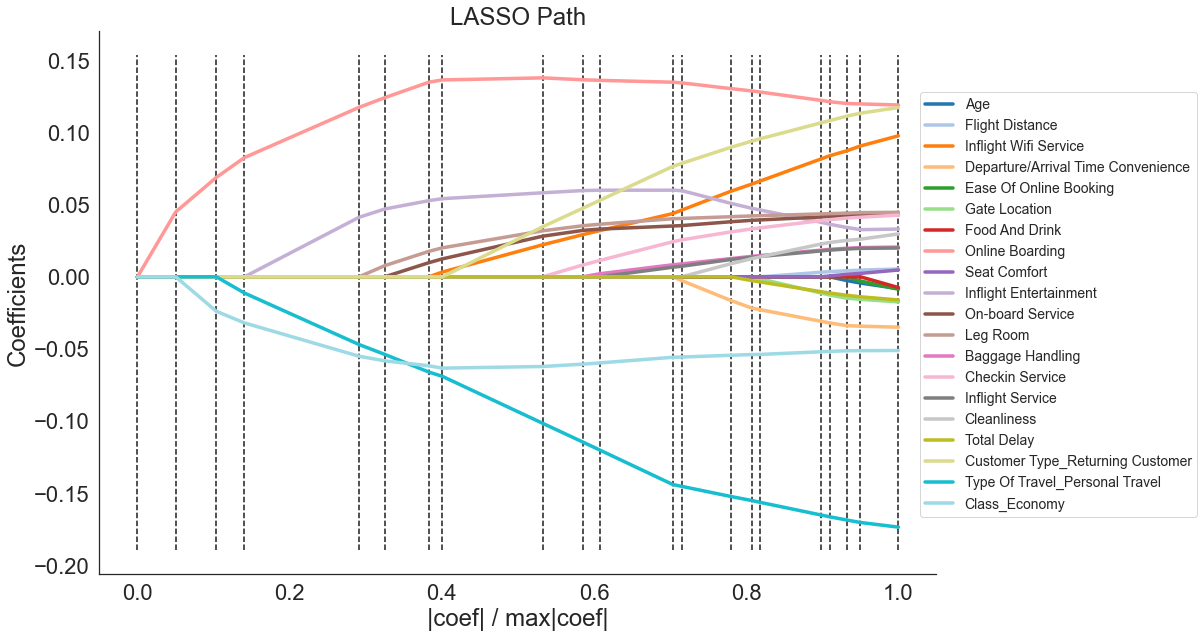

In [34]:
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

from cycler import cycler

# plotting the LARS path
sns.set(style='white',font_scale=2)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.rc('axes', prop_cycle =(cycler(color =['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A',
                                            '#D62728', '#FF9896', '#9467BD', '#C5B0D5', '#8C564B', '#C49C94',
                                            '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7', '#BCBD22', '#DBDB8D',
                                            '#17BECF', '#9EDAE5'])))

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T,linewidth=3.5)

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns,loc="upper right", bbox_to_anchor=(1.32, 0.9),fontsize=14)
sns.despine()
plt.savefig('lassoplot.png',transparent=True, bbox_inches='tight')

In [35]:
## DROP ##
#Total Delay
#Flight Distance
#Age
#Gate Location
#df1 = df1.drop(['Total Delay','Flight Distance','Age','Gate Location'],axis=1)
#df1 = df1.drop(['Ease Of Online Booking','Food And Drink','Gate Location','Seat Comfort'],axis=1)
#df1 = df1.drop(['Total Delay','Age','Gate Location','Departure/Arrival Time Convenience'],axis=1)
df1 = df1.drop(['Total Delay','Flight Distance','Age','Gate Location','Departure/Arrival Time Convenience'],axis=1)

# Model Selection
#### Find out the best model for the data through Regularization, Cross Validation with evaluation with f1 score:
- Logistic Regression (find out the best C)
- KNN (find out the best k)
- Gaussian Naive Bayes
- Decision Trees (find out the best depth)
- Random Forest (find out the best depth; no. of trees did not improve the model significantly)
- Ensemble (Taking all the models with the best hyperparameters)

#### Random Forest is selected as the best model, but Simple Validation is conducted to tune probability threshold:
- When threshold increased from 0.5 to 0.7, a better precision is obtained from 97% to 99%
- We need the best precision for our business solution

In [36]:
y = df1['Satisfaction']
X = df1.drop('Satisfaction',axis=1)

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [38]:
Cvec = np.linspace(0.001,2,100)
logit_model = LogisticRegressionCV(Cs = Cvec, cv=kf,max_iter=10000)
logit_model.fit(X_train_val, y_train_val)
logit_model.C_

array([0.04138384])

In [39]:
logit_model = LogisticRegression(C=logit_model.C_[0],max_iter=10000)
Mean_AUC_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_Logit_CV 

0.9574753085579836

In [40]:
Mean_Precision_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_Logit_CV 

0.8825738191988528

In [41]:
Mean_Recall_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_Logit_CV 

0.8689213943362002

In [42]:
X_train_val = X_train_val.reset_index().drop('index',axis=1)
y_train_val = y_train_val.reset_index().drop('index',axis=1)

In [43]:

#score = []
#for neighbors in range(5,11):
#    f1 = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=neighbors), X_train_val, y_train_val, cv=kf, scoring='f1'))
#    score.append(f1)
#    print(neighbors)
#best_neighbors = list(range(5,11))[np.argmax(score)]  
#best_f1 = max(score)
#print('The best k neighbours is {0} with f1-score of {1}'.format(best_neighbors,best_f1))   ''''''


In [44]:
Mean_AUC_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_KNN_CV 

0.9774336713393126

In [45]:
Mean_Precision_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_KNN_CV 

0.9529578915392566

In [46]:
Mean_Recall_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_KNN_CV 

0.9035544036808725

In [47]:
Mean_AUC_NB_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_NB_CV 

0.9471639267686747

In [48]:
Mean_Precision_NB_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_NB_CV 

0.8983471647930287

In [49]:
Mean_Recall_NB_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_NB_CV 

0.8405343563990776

In [50]:
#score = []
#for depth in range(5,20):
#    f1 = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=depth), X_train_val, y_train_val, cv=kf, scoring='f1'))
#    score.append(f1)
#    print(depth)
#best_depth = list(range(5,20))[np.argmax(score)]  
#best_f1 = max(score)
#print('The best depth is {0} with f1-score of {1}'.format(best_depth,best_f1)) 

In [51]:
Mean_AUC_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_tree_CV 

0.9792822199140494

In [52]:
Mean_Precision_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_tree_CV 

0.9634917552450382

In [53]:
Mean_Recall_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_tree_CV 

0.9271368648311021

In [54]:
#score = []
#for depth in range(8,13):
#    f1 = np.mean(cross_val_score(RandomForestClassifier(max_depth=depth,random_state=42), X_train_val, y_train_val, cv=kf, scoring='f1'))
#    score.append(f1)
#    print(depth)
#best_depth = list(range(8,13))[np.argmax(score)]  
#best_f1 = max(score)
#print('The best depth is {0} with f1-score of {1}'.format(best_depth,best_f1)) 

In [55]:
#parameters = {'n_estimators':[170,200,230],'max_depth':[10,15,17],'random_state':[42]}
#rf = RandomForestClassifier()
#clf = GridSearchCV(rf,parameters,scoring='f1')
#clf

In [56]:
#clf.fit(X_train_val, y_train_val)
#clf.best_estimator_

In [57]:
#clf.best_score_

In [58]:
Mean_AUC_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_forest_CV

0.9929174756792903

In [59]:
Mean_Precision_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_forest_CV

0.9727655008898376

In [60]:
Mean_Recall_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_forest_CV

0.9358494068346458

In [61]:
Log_Model = LogisticRegression(C=0.04138384,max_iter=10000)
KNN_Model = KNeighborsClassifier(n_neighbors=7)
NB_Model = GaussianNB()
Tree_Model = DecisionTreeClassifier(max_depth=12)
Forest_Model = RandomForestClassifier(max_depth=17,random_state=42)

model_list = [Log_Model,KNN_Model,NB_Model,Tree_Model,Forest_Model]
model_names = ["log_model", "knn_model", "nb_model", "tree_model", "forest_model"]
model = list(zip(model_names, model_list))

In [62]:
Mean_AUC_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_ensemble_CV

0.9878459961045852

In [63]:
Mean_Precision_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_ensemble_CV

0.9610362464987519

In [64]:
Mean_Recall_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_ensemble_CV

0.9179932596041158

In [65]:
model = ['Logistic Regression','KNN','Gaussian NB','Decision Trees','Random Forest','Ensemble']
scoring = ['AUC','Precision','Recall']
model_name = ['Logit','KNN','NB','tree','forest','ensemble']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('Mean_{0}_{1}_CV'.format(j,model_name[model.index(i)]))}
        model_list.append(model_dic)

In [66]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Logistic Regression,AUC,0.957475
1,Logistic Regression,Precision,0.882574
2,Logistic Regression,Recall,0.868921
3,KNN,AUC,0.977434
4,KNN,Precision,0.952958
5,KNN,Recall,0.903554
6,Gaussian NB,AUC,0.947164
7,Gaussian NB,Precision,0.898347
8,Gaussian NB,Recall,0.840534
9,Decision Trees,AUC,0.979282


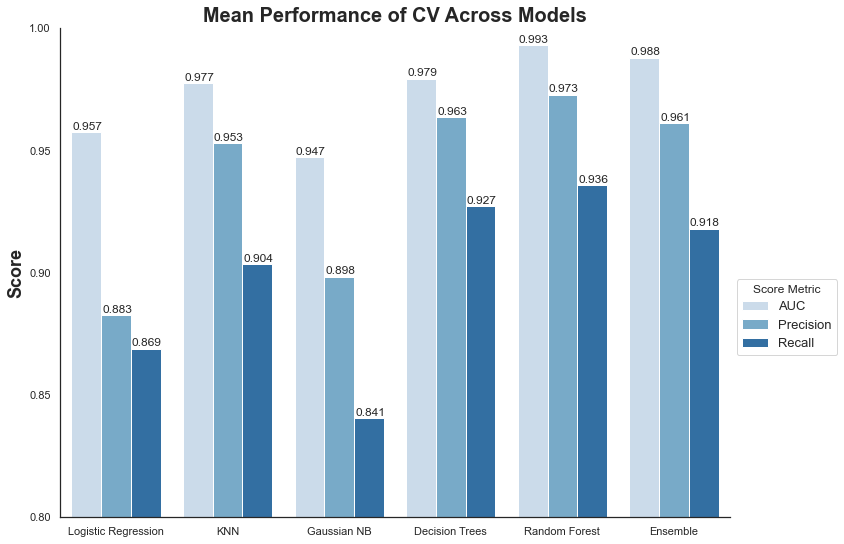

In [67]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of CV Across Models',weight='bold',fontsize=20)
sns.despine()
plt.savefig('modelbarplot.png',transparent=True, bbox_inches='tight')

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,random_state=42)

In [69]:
rf = RandomForestClassifier(max_depth=17, random_state=42)
rf.fit(X_train,y_train)
print("Random Forest score: {:.4f}".format(rf.score(X_train,y_train)))

Random Forest score: 0.9864


In [70]:
y_predict = rf.predict_proba(X_val)[:, 1] >= 0.5
precision_05 = precision_score(y_val, y_predict)
precision_05

0.9744755244755244

In [71]:
recall_05=recall_score(y_val, y_predict)
recall_05

0.9363346211993953

In [72]:
interactive(lambda threshold: make_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [73]:
y_predict = rf.predict_proba(X_val)[:, 1] >= 0.7
precision_07 = precision_score(y_val, y_predict)
precision_07

0.9933530280649926

In [74]:
recall_07=recall_score(y_val, y_predict)
recall_07

0.9037460104149169

In [75]:
roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

0.9927987107661415

In [76]:
SV_model = [{'Scoring':'Precision','Threshold':0.5,'Score':precision_05},{'Scoring':'Precision','Threshold':0.7,'Score':precision_07},{'Scoring':'Recall','Threshold':0.5,'Score':recall_05},{'Scoring':'Recall','Threshold':0.7,'Score':recall_07}]
SV_model = pd.DataFrame(SV_model)
SV_model

,Scoring,Threshold,Score
0,Precision,0.5,0.974476
1,Precision,0.7,0.993353
2,Recall,0.5,0.936335
3,Recall,0.7,0.903746


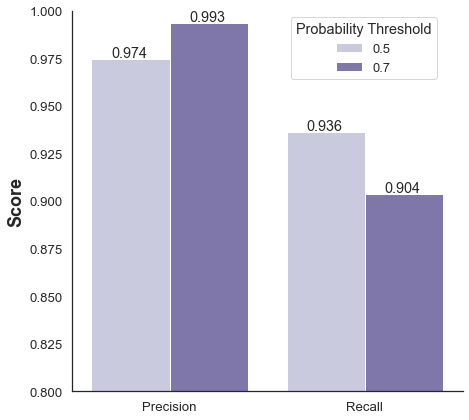

In [77]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[7,7])
ax = sns.barplot(x='Scoring',y='Score',data=SV_model,hue='Threshold',palette='Purples')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.1, p.get_height()+0.001))
plt.legend(title='Probability Threshold',loc="upper right", bbox_to_anchor=(0.95, 1),fontsize=13)
plt.ylim([0.8,1.0])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
sns.despine()
plt.savefig('probabilityplot.png',transparent=True, bbox_inches='tight')

# Model Evaluation

#### Model selected is Random Forest (depth=17) with threshold>=0.7. We evaluate the model on the test set:
- Plotting the confusion matrix, ROC curve
- Find out the precision, recall and AUC

#### The model is then tested on a business problem - How to ensure first-time customer satisfaction for economy/business:
- Random Forest Feature Importance is plotted to understand which feature scores to adjust
- Good Inflight Wifi service is crucial for customer satisfaction for both economy/business class customers
- Ease of online booking is important to business class customers

In [78]:
rf = RandomForestClassifier(max_depth=17,random_state=42)
rf.fit(X_train_val,y_train_val)
print("Random Forest score: {:.4f}".format(rf.score(X_train_val,y_train_val)))

Random Forest score: 0.9843


In [79]:
def make_confusion_matrix2(model, threshold=0.7):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    satisfaction_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=120)
    ax = sns.heatmap(satisfaction_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
           yticklabels=['Neutral/Dissatisfied', 'Satisfied']);   
    plt.xlabel('Prediction',weight='bold',fontsize=12)
    plt.ylabel('Actual',weight='bold',fontsize=12)
    plt.title('Confusion Matrix',weight='bold',fontsize=15)

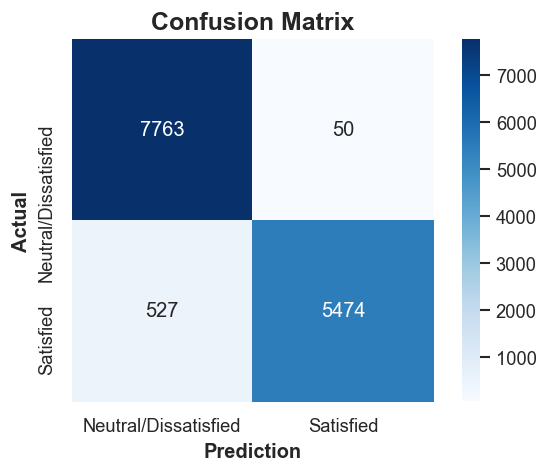

In [80]:
sns.set(style='white',font_scale=1)
make_confusion_matrix2(rf)
plt.savefig('confusionplot.png',transparent=True, bbox_inches='tight')

In [81]:
y_predict = rf.predict_proba(X_test)[:, 1]>=0.7
precision_score(y_test, y_predict)

0.9909485879797248

In [82]:
recall_score(y_test, y_predict)

0.9121813031161473

In [83]:
f1_score(y_test, y_predict)

0.9499349240780912

In [84]:
roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

0.9929527509739461

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

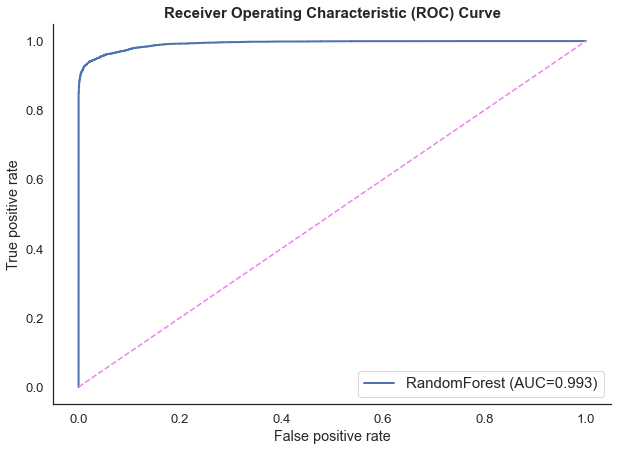

In [86]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[10,7])
plt.plot(fpr, tpr,lw=2,label='RandomForest (AUC={:.3f})'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right",fontsize=15)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15);
sns.despine()
plt.savefig('ROCplot.png',transparent=True, bbox_inches='tight')

In [87]:
rf.feature_importances_

array([0.1518041 , 0.03599584, 0.01504751, 0.18137475, 0.06194535,
       0.07224375, 0.04035524, 0.05287537, 0.03006541, 0.02685608,
       0.02759237, 0.03127238, 0.04532151, 0.11691215, 0.1103382 ])

In [88]:
df_impt = pd.DataFrame({'features':X_train_val.columns,'importance':rf.feature_importances_})
df_impt = df_impt.sort_values(by='importance',ascending=True)
df_impt

,features,importance
2,Food And Drink,0.015048
9,Checkin Service,0.026856
10,Inflight Service,0.027592
8,Baggage Handling,0.030065
11,Cleanliness,0.031272
1,Ease Of Online Booking,0.035996
6,On-board Service,0.040355
12,Customer Type_Returning Customer,0.045322
7,Leg Room,0.052875
4,Seat Comfort,0.061945


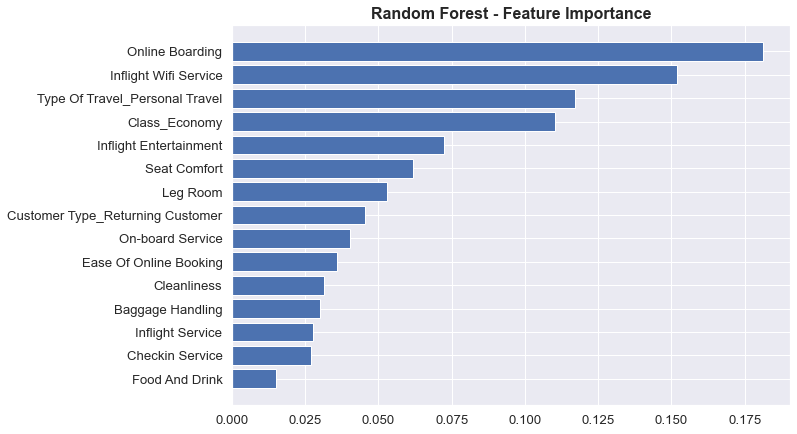

In [89]:
sns.set(style='darkgrid',font_scale=1.2)
fig = plt.figure(figsize=[10,7])
ax = plt.barh(df_impt['features'],df_impt['importance'])
plt.title('Random Forest - Feature Importance',weight='bold',fontsize=16)
plt.savefig('featureplot.png',transparent=True, bbox_inches='tight')

In [90]:
Test_Set = pd.DataFrame(y_test).join(X_test).join(pd.DataFrame(DF['Id']))
Test_Set['Predicted Satisfaction'] = (rf.predict_proba(X_test)[:, 1]>=0.7).astype(int)
Test_Set = Test_Set[['Satisfaction','Predicted Satisfaction','Inflight Wifi Service','Ease Of Online Booking','Food And Drink','Online Boarding','Seat Comfort','Inflight Entertainment','On-board Service','Leg Room','Baggage Handling','Checkin Service','Inflight Service','Cleanliness','Customer Type_Returning Customer','Type Of Travel_Personal Travel','Class_Economy']]
Test_Set.reset_index(inplace=True)
Test_Set.drop('index',axis=1,inplace=True)
Test_Set['Satisfaction'] = Test_Set['Satisfaction'].map({0:'Neutral/Dissatisfied',1:'Satisfied'})
Test_Set['Predicted Satisfaction'] = Test_Set['Predicted Satisfaction'].map({0:'Neutral/Dissatisfied',1:'Satisfied'})
Test_Set

,Satisfaction,Predicted Satisfaction,Inflight Wifi Service,Ease Of Online Booking,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
0,Neutral/Dissatisfied,Neutral/Dissatisfied,3,3,1,3,1,1,3,3,4,5,5,1,1,1,1
1,Satisfied,Satisfied,1,1,2,4,4,3,3,3,3,5,3,4,1,0,0
2,Satisfied,Satisfied,3,3,2,5,4,5,5,5,5,4,5,4,1,0,0
3,Satisfied,Satisfied,5,5,1,5,1,1,5,4,5,4,5,1,0,0,0
4,Neutral/Dissatisfied,Neutral/Dissatisfied,2,2,4,2,5,4,5,2,5,3,5,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13809,Neutral/Dissatisfied,Neutral/Dissatisfied,3,3,3,3,4,3,3,4,5,4,4,3,1,1,1
13810,Neutral/Dissatisfied,Neutral/Dissatisfied,3,3,4,5,4,5,5,3,5,4,5,5,1,1,1
13811,Neutral/Dissatisfied,Neutral/Dissatisfied,2,2,2,3,2,5,5,4,3,2,1,2,1,1,1
13812,Satisfied,Satisfied,3,3,2,4,5,5,5,4,5,5,5,4,1,0,0


In [91]:
Test_Set[(Test_Set['Class_Economy']==0)&(Test_Set['Satisfaction']=='Satisfied')&(Test_Set['Type Of Travel_Personal Travel']==0)&((Test_Set['Inflight Wifi Service']!=5))].head(100)

,Satisfaction,Predicted Satisfaction,Inflight Wifi Service,Ease Of Online Booking,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
1,Satisfied,Satisfied,1,1,2,4,4,3,3,3,3,5,3,4,1,0,0
2,Satisfied,Satisfied,3,3,2,5,4,5,5,5,5,4,5,4,1,0,0
10,Satisfied,Satisfied,3,3,3,1,5,4,4,4,4,4,4,4,1,0,0
16,Satisfied,Satisfied,3,3,4,5,4,5,5,5,5,5,5,5,1,0,0
21,Satisfied,Satisfied,3,1,3,4,4,4,4,4,4,5,4,5,1,0,0
25,Satisfied,Satisfied,3,3,5,4,5,5,5,5,5,3,5,5,1,0,0
27,Satisfied,Satisfied,3,3,5,3,1,5,5,5,5,1,5,5,1,0,0
32,Satisfied,Satisfied,3,1,3,5,5,5,5,5,5,5,5,5,1,0,0
42,Satisfied,Satisfied,3,3,4,4,4,4,3,1,1,4,4,4,1,0,0
47,Satisfied,Satisfied,3,3,2,5,4,4,4,4,4,4,4,3,1,0,0


In [92]:
Test_Set_Economy = Test_Set[(Test_Set['Class_Economy']==1)&(Test_Set['Type Of Travel_Personal Travel']==1)&(Test_Set['Customer Type_Returning Customer']==0)]
Test_Set_Economy['Satisfaction'] = Test_Set_Economy['Satisfaction'].map({'Neutral/Dissatisfied':0,'Satisfied':1})
Test_Set_Economy['Predicted Satisfaction'] = Test_Set_Economy['Predicted Satisfaction'].map({'Neutral/Dissatisfied':0,'Satisfied':1})
precision_score(Test_Set_Economy['Satisfaction'], Test_Set_Economy['Predicted Satisfaction'])

1.0

In [93]:
## NEW ECONOMY (Personal Travel) CUSTOMERS ##
neweconomy = []
neweconomy.append({'Inflight Wifi Service':3,'Ease Of Online Booking':3,'Food And Drink':3,'Online Boarding':3,'Seat Comfort':3,'Inflight Entertainment':3,'On-board Service':3,'Leg Room':3,'Baggage Handling':3,'Checkin Service':3,'Inflight Service':3,'Cleanliness':3,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':1,'Class_Economy':1})     
neweconomy.append({'Inflight Wifi Service':5,'Ease Of Online Booking':3,'Food And Drink':3,'Online Boarding':3,'Seat Comfort':3,'Inflight Entertainment':3,'On-board Service':3,'Leg Room':3,'Baggage Handling':3,'Checkin Service':3,'Inflight Service':3,'Cleanliness':3,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':1,'Class_Economy':1})
neweconomy.append({'Inflight Wifi Service':4,'Ease Of Online Booking':5,'Food And Drink':5,'Online Boarding':5,'Seat Comfort':5,'Inflight Entertainment':5,'On-board Service':5,'Leg Room':5,'Baggage Handling':5,'Checkin Service':5,'Inflight Service':5,'Cleanliness':5,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':1,'Class_Economy':1})
neweconomy.append({'Inflight Wifi Service':3,'Ease Of Online Booking':5,'Food And Drink':5,'Online Boarding':5,'Seat Comfort':5,'Inflight Entertainment':5,'On-board Service':5,'Leg Room':5,'Baggage Handling':5,'Checkin Service':5,'Inflight Service':5,'Cleanliness':5,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':1,'Class_Economy':1}) 
neweconomy = pd.DataFrame(neweconomy)

In [94]:
neweconomy['Predicted Satisfaction'] = (rf.predict_proba(neweconomy)[:, 1]>=0.7).astype(int)
neweconomy = neweconomy[['Predicted Satisfaction','Inflight Wifi Service','Ease Of Online Booking','Food And Drink','Online Boarding','Seat Comfort','Inflight Entertainment','On-board Service','Leg Room','Baggage Handling','Checkin Service','Inflight Service','Cleanliness','Customer Type_Returning Customer','Type Of Travel_Personal Travel','Class_Economy']]
neweconomy['Predicted Satisfaction'] = neweconomy['Predicted Satisfaction'].map({0:'Neutral/Dissatisfied',1:'Satisfied'})
neweconomy

,Predicted Satisfaction,Inflight Wifi Service,Ease Of Online Booking,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
0,Neutral/Dissatisfied,3,3,3,3,3,3,3,3,3,3,3,3,0,1,1
1,Satisfied,5,3,3,3,3,3,3,3,3,3,3,3,0,1,1
2,Neutral/Dissatisfied,4,5,5,5,5,5,5,5,5,5,5,5,0,1,1
3,Neutral/Dissatisfied,3,5,5,5,5,5,5,5,5,5,5,5,0,1,1


In [95]:
Test_Set_Business = Test_Set[(Test_Set['Class_Economy']==0)&(Test_Set['Type Of Travel_Personal Travel']==0)&(Test_Set['Customer Type_Returning Customer']==0)]
Test_Set_Business['Satisfaction'] = Test_Set_Business['Satisfaction'].map({'Neutral/Dissatisfied':0,'Satisfied':1})
Test_Set_Business['Predicted Satisfaction'] = Test_Set_Business['Predicted Satisfaction'].map({'Neutral/Dissatisfied':0,'Satisfied':1})
precision_score(Test_Set_Business['Satisfaction'], Test_Set_Business['Predicted Satisfaction'])

0.8871794871794871

In [96]:
## NEW Business (Business Travel) CUSTOMERS ##
newbusiness = []
newbusiness.append({'Inflight Wifi Service':3,'Ease Of Online Booking':3,'Food And Drink':3,'Online Boarding':3,'Seat Comfort':3,'Inflight Entertainment':3,'On-board Service':3,'Leg Room':3,'Baggage Handling':3,'Checkin Service':3,'Inflight Service':3,'Cleanliness':3,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})     
newbusiness.append({'Inflight Wifi Service':5,'Ease Of Online Booking':3,'Food And Drink':3,'Online Boarding':3,'Seat Comfort':3,'Inflight Entertainment':3,'On-board Service':3,'Leg Room':3,'Baggage Handling':3,'Checkin Service':3,'Inflight Service':3,'Cleanliness':3,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})
newbusiness.append({'Inflight Wifi Service':3,'Ease Of Online Booking':5,'Food And Drink':5,'Online Boarding':5,'Seat Comfort':5,'Inflight Entertainment':5,'On-board Service':5,'Leg Room':5,'Baggage Handling':5,'Checkin Service':5,'Inflight Service':5,'Cleanliness':5,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})
newbusiness.append({'Inflight Wifi Service':3,'Ease Of Online Booking':4,'Food And Drink':4,'Online Boarding':4,'Seat Comfort':4,'Inflight Entertainment':4,'On-board Service':4,'Leg Room':4,'Baggage Handling':4,'Checkin Service':4,'Inflight Service':4,'Cleanliness':4,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})
newbusiness.append({'Inflight Wifi Service':3,'Ease Of Online Booking':5,'Food And Drink':4,'Online Boarding':4,'Seat Comfort':4,'Inflight Entertainment':4,'On-board Service':4,'Leg Room':4,'Baggage Handling':4,'Checkin Service':4,'Inflight Service':4,'Cleanliness':4,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})
newbusiness.append({'Inflight Wifi Service':3,'Ease Of Online Booking':4,'Food And Drink':5,'Online Boarding':5,'Seat Comfort':5,'Inflight Entertainment':5,'On-board Service':5,'Leg Room':5,'Baggage Handling':5,'Checkin Service':5,'Inflight Service':5,'Cleanliness':5,'Customer Type_Returning Customer':0,'Type Of Travel_Personal Travel':0,'Class_Economy':0})
newbusiness = pd.DataFrame(newbusiness)

In [97]:
newbusiness['Predicted Satisfaction'] = (rf.predict_proba(newbusiness)[:, 1]>=0.5).astype(int)
newbusiness = newbusiness[['Predicted Satisfaction','Inflight Wifi Service','Ease Of Online Booking','Food And Drink','Online Boarding','Seat Comfort','Inflight Entertainment','On-board Service','Leg Room','Baggage Handling','Checkin Service','Inflight Service','Cleanliness','Customer Type_Returning Customer','Type Of Travel_Personal Travel','Class_Economy']]
newbusiness['Predicted Satisfaction'] = newbusiness['Predicted Satisfaction'].map({0:'Neutral/Dissatisfied',1:'Satisfied'})
newbusiness

,Predicted Satisfaction,Inflight Wifi Service,Ease Of Online Booking,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
0,Neutral/Dissatisfied,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0
1,Satisfied,5,3,3,3,3,3,3,3,3,3,3,3,0,0,0
2,Satisfied,3,5,5,5,5,5,5,5,5,5,5,5,0,0,0
3,Neutral/Dissatisfied,3,4,4,4,4,4,4,4,4,4,4,4,0,0,0
4,Satisfied,3,5,4,4,4,4,4,4,4,4,4,4,0,0,0
5,Neutral/Dissatisfied,3,4,5,5,5,5,5,5,5,5,5,5,0,0,0
